

```
# 코드로 형식 지정됨
```

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/06_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

# Chapter 10. 대규모 데이터셋 수집하기

요약: 파이썬 코드 생성하는 GPT 유사 모델 제작

- 대용량 데이터셋 수집과 처리
- 사용자 정의 토크나이저 만들기
- 여러 GPU에서 대규모로 모델 훈련하기

파라미터 수십억 개인 대규모 모델을 효과적으로 훈련하려면 분산 훈련을 위한 특별한 도구 필요</br>
트랜스포머스 Trainer, 파이토치 Accelerate

## 10.1 대규모 데이터셋 수집하기

Pretrained 모델 사용시 해당 모델의 토크나이저 사용</br>
But, 다른 도메인의 말뭉치에서 훈련한 토크나이저를 사용하면 토큰화 결과 좋지않음</br>
자동으로 취합된 데이터의 위험 요소 (편향, 저품질 데이터 포함 가능성)

훈련 데이터 양이 사전 훈련에 사용된 데이터 양과 비슷하고 계산에 필요한 자원이 주어진다면</br>
밑바닥부터 모델, 토크나이저 훈련

### 10.1.1 대규모 말뭉치 구축의 어려움

사전 훈련 말뭉치 풀질 > 사전 훈련 모델의 품질</br>
데이터셋이 커질수록 데이터셋의 내용과 생성 방법을 제어하기 어려워 편향되고 품질이 낮은 데이터에서 모델을 훈련할 위험 증가

예. BERT(BookCorpus), T5(C4)

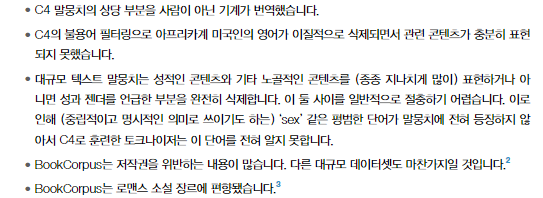

GPT(BookCorpus 훈련), GPT-2(웹 페이지, 블로그, Reddit 링크 뉴스 기사)

In [ ]:
from transformers import pipeline, set_seed

generation_gpt = pipeline("text-generation", model="openai-gpt")
gerneration_gpt2 = pipeline("text-generation", model="gpt2")

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def model_size(model):
  return sum(t.numel() for t in model.parameters())

print(f"GPT 크기: {model_size(generation_gpt.model)/1000**2}개 파라미터")
print(f"GPT2 크기: {model_size(gerneration_gpt2.model)/1000**2}개 파라미터")

GPT 크기: 116.534784개 파라미터
GPT2 크기: 124.439808개 파라미터


In [ ]:
def enum_pipeline_outputs(pipe, prompt, num_return_sequences):
  out = pipe(prompt, num_return_sequences=num_return_sequences, clean_up_tokenization_spaces=True)
  return "\n".join(f"{i+1.}" + s["generated_text"] for i, s in enumerate(out))

prompt = "\nWhen they came back"
print("GPT 자동 완성:\n" + enum_pipeline_outputs(generation_gpt, prompt, 3))
print(" ")
print("GPT2 자동 완성:\n" + enum_pipeline_outputs(gerneration_gpt2, prompt, 3))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


GPT 자동 완성:
1.0
When they came back, but i don't know. " 
 he sat up and his face turned red as he realized she had caught him. " i could have just as easily gone in there and blown myself up and your sister could have been killed
2.0
When they came back, we saw a man in a dirty suit who was driving from the farm. he was the person in the car, the person in the passenger seat, the person sitting. my mind started working again slowly, and i could see
3.0
When they came back later. at the table, he found four pairs of empty beer glasses, two empty ones, one empty, and a lone woman smoking as she listened to music outside with a large portable radio. he placed three twenties on the table
 
GPT2 자동 완성:
1.0
When they came back to the station, my son took the bus to the airport. The airport staff had told him to hold a ticket and so did their supervisor. My son came back, said I am going to meet them and was very polite
2.0
When they came back, the police found the bodies of the two teen boys

GPT 생성 문장: </br>
GPT2 생성 문장:

한 데이터셋에서 훈련한 모델은 언어 편향과 훈련 데이터에 있는 인구나 이벤트의 과대 또는 과소 표현을 반영

### 10.1.2 사용자 정의 코드 데이터셋 만들기

Github 저장소 가져오는 방식

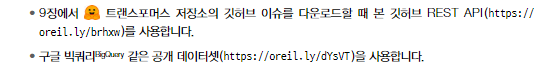

구글 빅쿼리로 데이터셋 만들기는 스킵

대신 허깅페이스 허브에서 데이터셋 바로 받기</br>
git clone https://huggingface.co/datasets/transformersbook/codeparrot

### 10.1.3 대용량 데이터셋 다루기

데이터셋은 메모리와 하드 드라이브 공간의 제약을 해결할 수 있도록 메모리 매핑과 스트리밍 기능 제공

**메모리 매핑**

메모리 제약 극복을 위해 데이터셋은 제로-카피, 제로-오버헤드 메커니즘 활성화

제로-카피: 커널 스페이스 ~ 유저 스페이스 간 복사 제거</br>
Zero-overhead: IO 작업시 오버헤드 제거 (최소화) - 페이지 폴트 발생시 처리 오버헤드 등 발생하긴 함

데이터셋을 메모리로 로딩하지 않고 읽기 전용 포인터를 열러 메모리 대신 사용 = 하드 드라이브를 메모리 확장으로 사용하는 것

##### 다른 실습 환경

##### **스트리밍**

큰 데이터셋은 서버 용량을 높이는 대신 데이터셋을 스트리밍할 수 있음

데이터셋을 로드할 때 하드 드라이브에 캐시 파일이 생성되지 않아 적은 양 메모리 사용</br>
배치 필요할 때만 메모리에 로드

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset, DownloadConfig

In [17]:
from datasets import load_dataset, DownloadConfig

download_config = DownloadConfig(delete_extracted=True)
dataset = load_dataset("./codeparrot", split="train",
                       download_config=download_config)

ModuleNotFoundError: No module named 'datasets'

In [3]:
remote_dataset = load_dataset('transformersbook/codeparrot', split="train",
                              streaming=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

**허깅페이스에 데이터셋 추가하기**

https://huggingface.co/datasets/transformersbook/codeparrot</br>
https://huggingface.co/datasets/transformersbook/codeparrot-train</br>
https://huggingface.co/datasets/transformersbook/codeparrot-valid

데이터셋 수집 로딩

## 10.2 토크나이저 구축하기

Pretrained 모델은 Pretrained에서 사용된 tokenizer</br>
새로운 모델에 준비된 tokenizer 사용은 최적이 아닐수도...

T5 토크나이저: C4 말뭉치, 불용어 필터링, 'sex' 단어 모름</br>
CamemBERT 토크나이저:OSCAR 말뭉치, 프랑스어 텍스트, 'being' 모름

In [2]:
from transformers import AutoTokenizer

def tok_list(tokenizer, string):
    input_ids = tokenizer(string, add_special_tokens=False)["input_ids"]
    return [tokenizer.decode(tok) for tok in input_ids]

tokenizer_T5 = AutoTokenizer.from_pretrained("t5-base")
tokenizer_camembert = AutoTokenizer.from_pretrained("camembert-base")

print(f'"sex"에 대한 T5 토큰: {tok_list(tokenizer_T5,"sex")}')
print(f'"being"에 대한 CamemBERT 토큰: {tok_list(tokenizer_camembert,"being")}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

"sex"에 대한 T5 토큰: ['', 's', 'ex']
"being"에 대한 CamemBERT 토큰: ['be', 'ing']


토크나이저 훈련시 사용한 데이터셋의 도메인과 전처리 방식 이해 필요</br>
토크나이저와 모델은 데이터셋에 편향

최적의 토크나이저를 얻으려면 토크나이저를 직접 훈련 필요

### 10.2.1 토크나이저 모델

토크나이저 파이프라인
- 정규화
- 사전 토큰화
- 토크나이저 모델(훈련)
- 사후 처리

BPE, WordPiece, 유니그램 같은 부분단어 토큰화 알고리즘 사용
- BPE: 단일 문자 단위 리스트로 시작해 가장 자주 함께 등장한 기본 단위를 합쳐 어휘 사전에 추가하는 방식으로 새 토큰을 만들어 사전에 정의된 크기의 어휘 사전 생성
- 유니그램: 말뭉치 모든 단어와 가능성 있는 부분단어로 기본 어휘사전 구성, 목표 크기에 도달할 때까지 유용성이 떨어지는 토큰 삭제 및 분할 하여 어휘사전 생성
- WordPiece: 유니그램 전신, 구글에서 오픈소스 공개X

### 10.2.2 토크나이저 성능 측정하기

토크나이저 최적성, 성능 측정 방법
- 부분단어 생산력: 토큰화된 단어마다 생성되는 부분단어의 평균 개수 계산
- 연속 단어 비욜: 말뭉치에서 적어도 두 개의 부분 토큰으로 분할된 토큰화된 단어 비율
- 토큰화된 말뭉치에서 알 수 없는 단어나 거의 사용되지 않은 토큰의 비율 같은 커버리지 측정값
* 기타: 철자 오류, 잡음 등에 대한 견고성, 도메인 밖 샘플에 대한 모델 성능 등

실질적으로는 토크나이저와 모델의 성능 결과로서 토크나이저 성능 평가

### 10.2.3 파이썬 코드를 위한 토크나이저

파이썬 코드
- 공백 중요
- 줄바꿈 의미 없음
- 밑줄 문자, 구두점 분할 X

GPT-2 토크나이저: 공백 유지하므로 파이썬 코드 토크나이저로 좋음

In [3]:
from transformers import AutoTokenizer

python_code = r"""def say_hello():
    print("Hello, World!")
# Print it
say_hello()
"""
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(tokenizer(python_code).tokens())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!"', ')', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


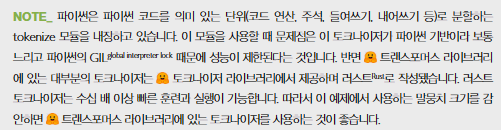

In [2]:
print(tokenizer.backend_tokenizer.normalizer)

None


→ GPT-2 정규화 X

In [3]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():', (13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello', (28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ċ', (43, 44)), ('#', (44, 45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('say', (55, 58)), ('_', (58, 59)), ('hello', (59, 64)), ('()', (64, 66)), ('Ċ', (66, 67))]


→ 사전 토큰화
- 숫자: 토크나이저 문자열과 토큰 사이를 전환하는데 유용한 오프셋 트래킹 기능 존재,
토큰이 원본 문자열의 위치를 나타냄, 일부 문자가 정규화 단계에서 삭제되더라도 각 토큰을 원본 문자열의 위치 파악 가능
- 특이한 문자(C',G'): 유니코드 문자가 아닌 바이트 단위로 동작
유니코드 문자는 1~4바이트로 구성
유니코드 알파벳: 143,859개 유니코드 문자
바이트 알파벳: 256개
유니코드 문자를 바이트 시퀀스로 변환
바이트를 사용하면 UTF-8로 구성된 어떤 문자열도 256개 알파벳으로 구성된 더 긴 문자열 표현 가능

In [4]:
a, e = u"a", u"€"
byte = ord(a.encode("utf-8"))
print(f'`{a}`는 단일 바이트 `{a.encode("utf-8")}`로 인코딩됩니다: {byte}')
byte = [ord(chr(i)) for i in e.encode("utf-8")]
print(f'`{e}`는 세 바이트 `{e.encode("utf-8")}`로 인코딩됩니다: {byte}')

`a`는 단일 바이트 `b'a'`로 인코딩됩니다: 97
`€`는 세 바이트 `b'\xe2\x82\xac'`로 인코딩됩니다: [226, 130, 172]


143,859개 유니코드 문자와 그 조합을 어휘사전에 포함하면 양이 큼, 더구나 임베딩 층은 토큰마다 벡터 하나를 할당하는데...

어휘사전으로 256개 바이트값만 사용한다면 입력 시퀀스를 작은 조각들로 분할하기 때문에 모델에 긴 입력이 들어가 유니코드 문자, 단어 재구성에 많은 컴퓨팅 소모

→ 이에 가장 자주 등장한 바이트 조합으로 256개 단어 어휘를 확장하여 어휘 사전을 중간 규모로 만드는 것이 BPE 알고리즘</br>
t, h 함께 자주 등장하면 th를 어휘사전에 추가

BPE(Byte Pair Encoding) vs Byte-level

In [5]:
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

print(f'기본 어휘 사전 크기: {len(base_vocab)}')
print(f'첫 번째 원소: `{base_vocab[0]}`, last element: `{base_vocab[-1]}`')

기본 어휘 사전 크기: 256
첫 번째 원소: `!`, last element: `Ń`


In [6]:
byte_to_unicode_map

{33: '!',
 34: '"',
 35: '#',
 36: '$',
 37: '%',
 38: '&',
 39: "'",
 40: '(',
 41: ')',
 42: '*',
 43: '+',
 44: ',',
 45: '-',
 46: '.',
 47: '/',
 48: '0',
 49: '1',
 50: '2',
 51: '3',
 52: '4',
 53: '5',
 54: '6',
 55: '7',
 56: '8',
 57: '9',
 58: ':',
 59: ';',
 60: '<',
 61: '=',
 62: '>',
 63: '?',
 64: '@',
 65: 'A',
 66: 'B',
 67: 'C',
 68: 'D',
 69: 'E',
 70: 'F',
 71: 'G',
 72: 'H',
 73: 'I',
 74: 'J',
 75: 'K',
 76: 'L',
 77: 'M',
 78: 'N',
 79: 'O',
 80: 'P',
 81: 'Q',
 82: 'R',
 83: 'S',
 84: 'T',
 85: 'U',
 86: 'V',
 87: 'W',
 88: 'X',
 89: 'Y',
 90: 'Z',
 91: '[',
 92: '\\',
 93: ']',
 94: '^',
 95: '_',
 96: '`',
 97: 'a',
 98: 'b',
 99: 'c',
 100: 'd',
 101: 'e',
 102: 'f',
 103: 'g',
 104: 'h',
 105: 'i',
 106: 'j',
 107: 'k',
 108: 'l',
 109: 'm',
 110: 'n',
 111: 'o',
 112: 'p',
 113: 'q',
 114: 'r',
 115: 's',
 116: 't',
 117: 'u',
 118: 'v',
 119: 'w',
 120: 'x',
 121: 'y',
 122: 'z',
 123: '{',
 124: '|',
 125: '}',
 126: '~',
 161: '¡',
 162: '¢',
 163: '£',

In [7]:
len(byte_to_unicode_map)

256

In [8]:
unicode_to_byte_map

{'!': 33,
 '"': 34,
 '#': 35,
 '$': 36,
 '%': 37,
 '&': 38,
 "'": 39,
 '(': 40,
 ')': 41,
 '*': 42,
 '+': 43,
 ',': 44,
 '-': 45,
 '.': 46,
 '/': 47,
 '0': 48,
 '1': 49,
 '2': 50,
 '3': 51,
 '4': 52,
 '5': 53,
 '6': 54,
 '7': 55,
 '8': 56,
 '9': 57,
 ':': 58,
 ';': 59,
 '<': 60,
 '=': 61,
 '>': 62,
 '?': 63,
 '@': 64,
 'A': 65,
 'B': 66,
 'C': 67,
 'D': 68,
 'E': 69,
 'F': 70,
 'G': 71,
 'H': 72,
 'I': 73,
 'J': 74,
 'K': 75,
 'L': 76,
 'M': 77,
 'N': 78,
 'O': 79,
 'P': 80,
 'Q': 81,
 'R': 82,
 'S': 83,
 'T': 84,
 'U': 85,
 'V': 86,
 'W': 87,
 'X': 88,
 'Y': 89,
 'Z': 90,
 '[': 91,
 '\\': 92,
 ']': 93,
 '^': 94,
 '_': 95,
 '`': 96,
 'a': 97,
 'b': 98,
 'c': 99,
 'd': 100,
 'e': 101,
 'f': 102,
 'g': 103,
 'h': 104,
 'i': 105,
 'j': 106,
 'k': 107,
 'l': 108,
 'm': 109,
 'n': 110,
 'o': 111,
 'p': 112,
 'q': 113,
 'r': 114,
 's': 115,
 't': 116,
 'u': 117,
 'v': 118,
 'w': 119,
 'x': 120,
 'y': 121,
 'z': 122,
 '{': 123,
 '|': 124,
 '}': 125,
 '~': 126,
 '¡': 161,
 '¢': 162,
 '£': 163,

In [9]:
base_vocab

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '~',
 '¡',
 '¢',
 '£',
 '¤',
 '¥',
 '¦',
 '§',
 '¨',
 '©',
 'ª',
 '«',
 '¬',
 '®',
 '¯',
 '°',
 '±',
 '²',
 '³',
 '´',
 'µ',
 '¶',
 '·',
 '¸',
 '¹',
 'º',
 '»',
 '¼',
 '½',
 '¾',
 '¿',
 'À',
 'Á',
 'Â',
 'Ã',
 'Ä',
 'Å',
 'Æ',
 'Ç',
 'È',
 'É',
 'Ê',
 'Ë',
 'Ì',
 'Í',
 'Î',
 'Ï',
 'Ð',
 'Ñ',
 'Ò',
 'Ó',
 'Ô',
 'Õ',
 'Ö',
 '×',
 'Ø',
 'Ù',
 'Ú',
 'Û',
 'Ü',
 'Ý',
 'Þ',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê

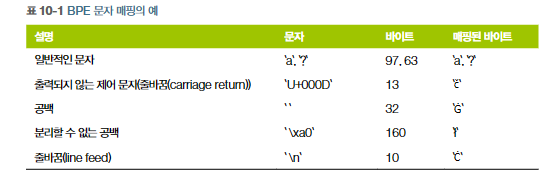

In [1]:
# BPE 문자 매핑의 예
import pandas as pd
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode

byte_to_unicode_map = bytes_to_unicode()
unicode_to_byte_map = dict((v, k) for k, v in byte_to_unicode_map.items())
base_vocab = list(unicode_to_byte_map.keys())

examples = [
    ['Regular characters', '`a` and `?`', f'{ord("a")} and {ord("?")}' , f'`{byte_to_unicode_map[ord("a")]}` and `{byte_to_unicode_map[ord("?")]}`'],
    ['Nonprintable control character (carriage return)', '`U+000D`', f'13', f'`{byte_to_unicode_map[13]}`'],
    ['A space', '` `', f'{ord(" ")}', f'`{byte_to_unicode_map[ord(" ")]}`'],
    ['A nonbreakable space', '`\\xa0`', '160', f'`{byte_to_unicode_map[ord(chr(160))]}`'],
    ['A newline character', '`\\n`', '10', f'`{byte_to_unicode_map[ord(chr(10))]}`'],
]

pd.DataFrame(examples, columns = ['Description', 'Character', 'Bytes', 'Mapped bytes'])

,Description,Character,Bytes,Mapped bytes
0,Regular characters,`a` and `?`,97 and 63,`a` and `?`
1,Nonprintable control character (carriage return),`U+000D`,13,`č`
2,A space,` `,32,`Ġ`
3,A nonbreakable space,`\xa0`,160,`ł`
4,A newline character,`\n`,10,`Ċ`


In [4]:
print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(python_code))

[('def', (0, 3)), ('Ġsay', (3, 7)), ('_', (7, 8)), ('hello', (8, 13)), ('():', (13, 16)), ('ĊĠĠĠ', (16, 20)), ('Ġprint', (20, 26)), ('("', (26, 28)), ('Hello', (28, 33)), (',', (33, 34)), ('ĠWorld', (34, 40)), ('!")', (40, 43)), ('Ċ', (43, 44)), ('#', (44, 45)), ('ĠPrint', (45, 51)), ('Ġit', (51, 54)), ('Ċ', (54, 55)), ('say', (55, 58)), ('_', (58, 59)), ('hello', (59, 64)), ('()', (64, 66)), ('Ċ', (66, 67))]


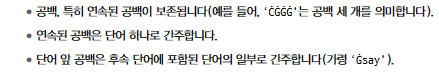

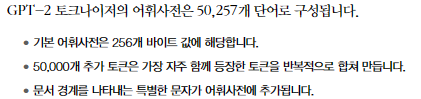

In [5]:
print(f"어휘 사전의 크기: {len(tokenizer)}")

어휘 사전의 크기: 50257


In [7]:
python_code

'def say_hello():\n    print("Hello, World!")\n# Print it\nsay_hello()\n'

In [6]:

print(tokenizer(python_code).tokens())

['def', 'Ġsay', '_', 'hello', '():', 'Ċ', 'Ġ', 'Ġ', 'Ġ', 'Ġprint', '("', 'Hello', ',', 'ĠWorld', '!"', ')', 'Ċ', '#', 'ĠPrint', 'Ġit', 'Ċ', 'say', '_', 'hello', '()', 'Ċ']


BPE 토크나이저는 들여쓰기에 잇는 여러 공백을 몇 개의 연속된 공백으로 나눔</br>
→ 토크나이저 모델이 주어진 데이터셋의 도메인에 잘 맞지 않음, 재훈련 필요

### 10.2.4 토크나이저 훈련하기

BPE 토크나이저 재훈련시 고려사항

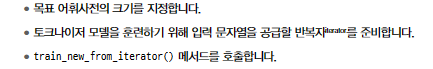

딥러닝 모델: 말뭉치에서 특정 세부 내용을 많이 기억하도록 훈련</br>
토크나이저: 말뭉치에서 자주 등장한 문자 조합을 알아내는 훈련</br>
토크나이저는 대규모 말뭉치에서 훈련할 필요없음
해당 도메인을 대표하고 통계적으로 의미있는 값 추출

In [8]:
tokens = sorted(tokenizer.vocab.items(), key=lambda x: len(x[0]), reverse=True)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:8]]);

TypeError: argument 'tokens': Can't extract `str` to `Vec`

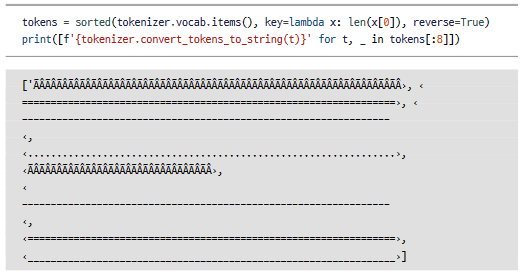

레딧에서 얻은 말뭉치로 훈련되어 가장 긴 단어에 '구분선'이 표시

In [9]:
tokens

[('ÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤ',
  35496),
 ('Ġ=================================================================', 38093),
 ('Ġ----------------------------------------------------------------', 16529),
 ('================================================================', 23926),
 ('________________________________________________________________', 27193),
 ('----------------------------------------------------------------', 10097),
 ('................................................................', 23193),
 ('ÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤ', 23090),
 ('--------------------------------------------------------', 43801),
 ('------------------------------------------------', 47232),
 ('âĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶâĢĶ', 30542),
 ('Ġ=================================', 46111),
 ('Ġ********************************', 41906),
 ('Ġ--------------

In [10]:
tokens = sorted(tokenizer.vocab.items(), key=lambda x: x[1], reverse=True)
print([f'{tokenizer.convert_tokens_to_string(t)}' for t, _ in tokens[:12]]);

TypeError: argument 'tokens': Can't extract `str` to `Vec`

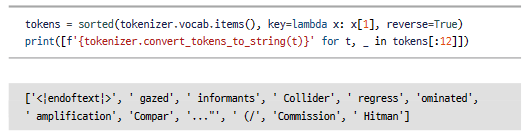

In [14]:
tokens = sorted(tokenizer.vocab.items(), key=lambda x: x[1], reverse=True)
# 상위 12개 토큰만 추출하여 토큰 리스트 생성
top_tokens = [t for t, _ in tokens[:12]]
# 토큰 리스트를 문자열로 변환
top_tokens_str = tokenizer.convert_tokens_to_string(top_tokens)
print(top_tokens_str)

<|endoftext|> gazed informants Collider regressominated amplificationCompar…." (/Commission Hitman


In [15]:
top_tokens

['<|endoftext|>',
 'Ġgazed',
 'Ġinformants',
 'ĠCollider',
 'Ġregress',
 'ominated',
 'Ġamplification',
 'Compar',
 'âĢ¦."',
 'Ġ(/',
 'Commission',
 'ĠHitman']

|endoftext|: 텍스트 시퀀스 끝 지정 특수 토큰, BPE 어휘사전 구축 후 추가됨

**예제 말뭉치에서 새 토크나이저를 훈련하고 학습된 어휘사전 생성**


In [23]:
from tqdm.auto import tqdm

# 처리할 데이터 길이
length = 100000
# 사용할 데이터셋 이름
dataset_name = 'transformersbook/codeparrot-train'
# 스트리밍 모드로 로드...필요할 때마다 부분적으로 로드
dataset = load_dataset(dataset_name, split="train", streaming=True)
# 데이터셋의 이터레이터 생
iter_dataset = iter(dataset)

# 배치 크기 10에 따라 데이터셋을 나누어 제공
def batch_iterator(batch_size=10):
    for _ in tqdm(range(0, length, batch_size)):
      # 각 반복에서 배치 사이즈만큼 'content' 필드를 추출하여 리스트로 만들고 반환
        yield [next(iter_dataset)['content'] for _ in range(batch_size)]

# 새 토크나이너 훈련
# 새 토크나이저 어휘 크기 12,500, 토큰나이저가 학습하고 인식할 수 잇는 고유 토큰의 최대 개수
# 토크나이저가 초기에 고려할 알파벳 기본 어휘 세트, base_vocab
new_tokenizer = tokenizer.train_new_from_iterator(batch_iterator(),
                                                  vocab_size=12500,
                                                  initial_alphabet=base_vocab)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

BPE 알고리즘이 만든 첫 단어

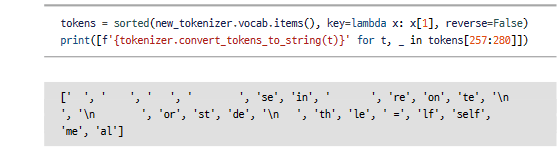

파이썬 예약어(들여쓰기, 공백 토큰, self, or, in 등)

BPE 알고리즘이 만든 마지막 단어

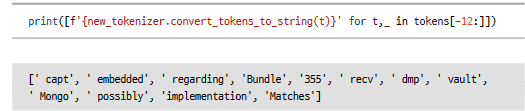

recv와 같은 일반적인 단어, 주석에서 나온 잡음 단어

예제코드 토큰화

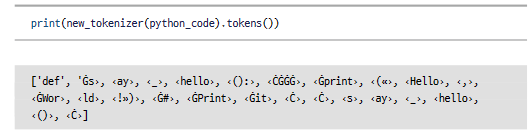

파이썬의 예약어가 어휘사전에 있는지 확인

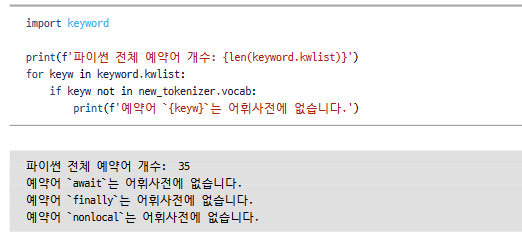

파이썬 예약어 예시</br>
False, True, None, and, or, not 등

더 많은 샘플을 가져와 더 큰 어휘사전 만들고 토크나이저 훈련</br>
어휘사전 32,768개 단어로 구성

In [ ]:
length = 200000
new_tokenizer_larger = tokenizer.train_new_from_iterator(batch_iterator(),
    vocab_size=32768, initial_alphabet=base_vocab)

마지막 토큰에 일반적인 프로그래밍 예약어가 보임, GOOD.

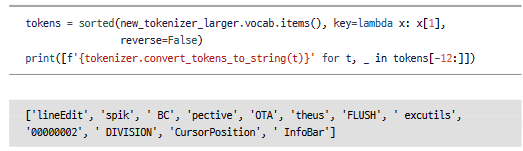

새 토크나이저로 샘플 코드화

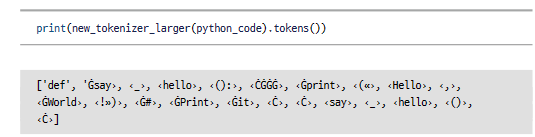

파이썬 예약어 조사

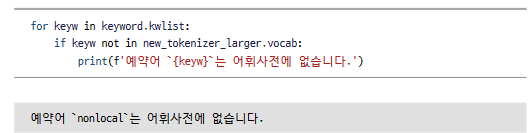

### 10.2.5 허브에 사용자 정의 토크나이저 저장하기

In [ ]:
model_ckpt = "codeparrot"
org = "transformersbook"
new_tokenizer_larger.push_to_hub(model_ckpt, organization=org)

In [ ]:
reloaded_tokenizer = AutoTokenizer.from_pretrained(org + "/" + model_ckpt)
print(reloaded_tokenizer(python_code).tokens())

## 10.3 밑바닥부터 모델을 훈련하기

1. 작업에 가장 잘 맞는 아키텍처 결정
2. 사전 훈련된 가중치 없는 새 모델 초기화
3. 사용자 정의 데이터 로딩 클래스 생성
4. 확장 가능한 훈련 루프

downgit으로 아래 스크립트 다운로드</br>
https://github.com/huggingface/transformers/tree/main/examples/research_projects/codeparrot

### 10.3.1 사전 훈련 목표

대량의 코드 베이스의 형태

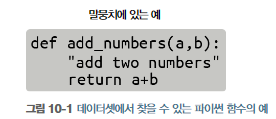

## 모델 선정

**코잘 언어 모델링(Causal language modeling)**

코드 샘플 시작 부분을 모델에게 제공하고 코드 나머지 부분 완성하라고 요청</br>
레이블이 없는 데이터셋을 사용하는 자기 지도 훈련 목표</br>
코드 자동 완성은 GPT 계열의 디코더 전용 아키텍처가 적절

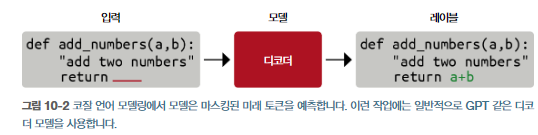

**마스크드 언어 모델링(masked language modeling) or 잡음 제거 목표(denoising objective)**

모델에게 잡음이 섞인 코드 샘플을 주고 깨끗한 원본 샘플을 재구성하라고 요청</br>
자기 지도 훈련</br>
BERT와 XLM-RoBERTa 같은 모델들이 이 방식으로 훈련됨</br>
레이블링된 샘플이 제한적인 후속 작업의 경우 대규모 말뭉치에서 훈련된 마스크드 언어 모델을 사용해 미세 튜닝 가능

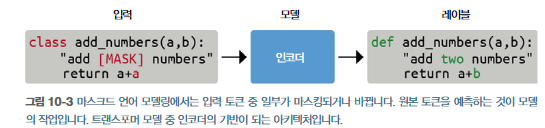

**시퀀스-투-시퀀스 훈련**

코드, 주석을 쌍으로 대규모 데이터셋을 구축하는 작업</br>
입력, 레이블을 사용하는 지도 학습 문제</br>
코드에서 주석 예측, 주석에서 코드 예측하는 훈련</br>
후속 작업은 코드로부터 문서 생성, 문서로부터 코드 생성하는 것</br>
T5, BART, PEGASUS 같은 인코더-디코더 모델이 적절

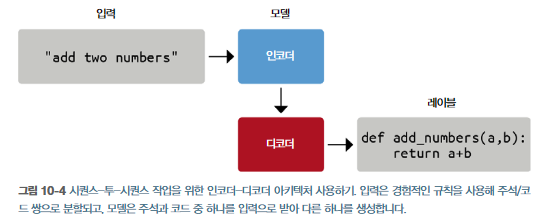

실습에서는 코드 자동 완성 모델 구축이 목표</br>
→ 코잘 언어 모델과 GPT 아키텍쳐 선택

### 10.3.2 모델 초기화

In [7]:
model_ckpt = "codeparrot"
org = "transformersbook"
def model_size(model):
    return sum(t.numel() for t in model.parameters())

In [5]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(org + "/" + model_ckpt)
config = AutoConfig.from_pretrained("gpt2", vocab_size=len(tokenizer))
model = AutoModelForCausalLM.from_config(config)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [8]:
print(f'GPT-2 크기: {model_size(model)/1000**2:.1f}M parameters')

GPT-2 크기: 111.0M parameters


cf.

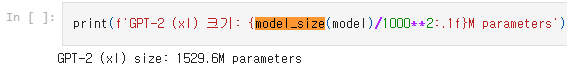

In [10]:
import huggingface_hub
huggingface_hub.login()

새로 초기화한 모델을 허깅페이스 허브에 push

In [ ]:
model.save_pretrained("models/" + model_ckpt+ "-small", push_to_hub=True, organization=org)

### 10.3.3 데이터로더 구축하기

훈련 효율 극대화하도록 문맥 크기를 꽉 채운 시퀀스를 모델에 제공</br>
모델 문맥 크기 1,024개 토큰이면 훈련할 때 매번 1,024개 토큰 시퀀스 제공

시퀀스 마지막을 자르거나 패딩해야...훈련 효율성 및 패딩과 마스킹에 대한 컴퓨팅 제약 발생

해결책

여러 샘플 토큰화하고 특수한 EOS 토큰으로 연결에 매우 긴 시퀀스를 생성</br>
이 시퀀스를 동일 크기의 chunk로 나누면 데이터 손실 미미

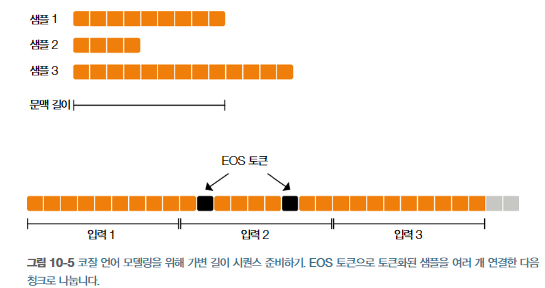

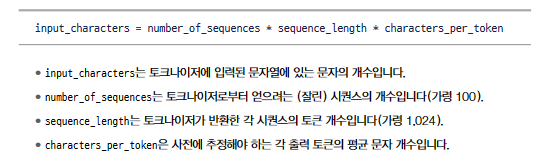

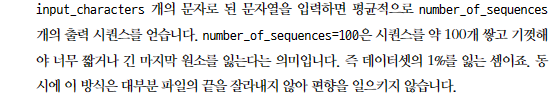

In [20]:
examples, total_characters, total_tokens = 500, 0, 0
dataset = load_dataset('transformersbook/codeparrot-train', split='train',
                       streaming=True)

for _, example in tqdm(zip(range(examples), iter(dataset)), total=examples):
    total_characters += len(example['content'])
    total_tokens += len(tokenizer(example['content']).tokens())

characters_per_token = total_characters / total_tokens

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Resolving data files:   0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2605 > 1024). Running this sequence through the model will result in indexing errors


데이터셋에 있는 토큰의 평균 문자 길이

In [21]:
print(characters_per_token)

3.6233025034779565


모델에게 일정한 길이의 입력을 위한 IterableDataset을 상속하여 __iter__() 함수 작성

In [22]:
import torch
from torch.utils.data import IterableDataset

class ConstantLengthDataset(IterableDataset):

    def __init__(self, tokenizer, dataset, seq_length=1024,
                 num_of_sequences=1024, chars_per_token=3.6):
        self.tokenizer = tokenizer  # 토큰화 수행 개
        self.concat_token_id = tokenizer.eos_token_id # 문장 분리
        self.dataset = dataset  # 입력 데이터셋
        self.seq_length = seq_length  # 출력될 토큰 시퀀스의 길이
        self.input_characters = seq_length * chars_per_token * num_of_sequences # 버퍼에 저장될 최대 문자 수

    def __iter__(self):
        iterator = iter(self.dataset)
        more_examples = True
        # 버퍼 채우기
        while more_examples:
            buffer, buffer_len = [], 0
            while True:
                if buffer_len >= self.input_characters:
                    m=f"Buffer full: {buffer_len}>={self.input_characters:.0f}"
                    print(m)
                    break
                try:
                    m=f"Fill buffer: {buffer_len}<{self.input_characters:.0f}"
                    print(m)
                    buffer.append(next(iterator)["content"])
                    buffer_len += len(buffer[-1])
                except StopIteration:
                    iterator = iter(self.dataset)

            all_token_ids = []
            tokenized_inputs = self.tokenizer(buffer, truncation=False)
            # 버퍼 내용을 tokenizer로 토크나이즈
            for tokenized_input in tokenized_inputs['input_ids']: # 토큰 ID 시퀀스 추
                all_token_ids.extend(tokenized_input + [self.concat_token_id])  # 문장 분리자
            # 시퀀스 생성, all_token_ids에 저장된 토큰 ID들을 seq_length의 길이에 맞게 분할
            for i in range(0, len(all_token_ids), self.seq_length):
                input_ids = all_token_ids[i : i + self.seq_length]
                if len(input_ids) == self.seq_length:
                    yield torch.tensor(input_ids)

__iter__() 메서드: 충분한 개수 문자를 포함할 때까지 문자열 버퍼 채움

In [23]:
shuffled_dataset = dataset.shuffle(buffer_size=100)
constant_length_dataset = ConstantLengthDataset(tokenizer, shuffled_dataset,
                                                num_of_sequences=10)
dataset_iterator = iter(constant_length_dataset)

lengths = [len(b) for _, b in zip(range(5), dataset_iterator)]
print(f"시퀀스 길이: {lengths}")

Fill buffer: 0<36864
Fill buffer: 5605<36864
Fill buffer: 8605<36864
Fill buffer: 10687<36864
Fill buffer: 22673<36864
Buffer full: 47579>=36864
시퀀스 길이: [1024, 1024, 1024, 1024, 1024]


In [24]:
tokenizer

GPT2TokenizerFast(name_or_path='transformersbook/codeparrot', vocab_size=32768, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [28]:
test = [b for _, b in zip(range(5), dataset_iterator)]

Fill buffer: 0<36864
Fill buffer: 5650<36864
Fill buffer: 9796<36864
Fill buffer: 12466<36864
Fill buffer: 13694<36864
Fill buffer: 22604<36864
Fill buffer: 26044<36864
Buffer full: 113272>=36864


In [33]:
test

[tensor([  14, 2866,   84,  ...,  488,   26,  355]),
 tensor([ 646,  747,  199,  ...,   63, 2083,  275]),
 tensor([18990,     8, 15380,  ...,  3530,   435,   536]),
 tensor([  435,   283, 10805,  ...,    61,   272,   776]),
 tensor([  272,   922,    63,  ..., 21977,    63,  4782])]

### 10.3.4 훈련 루프 정의하기

사용자 정의 언어 모델 훈련 제약 조건은 GPU 메모리 제한
→ 여러 개 GPU 훈련 사용을 위한 데이터 병렬화 구현

엑셀러레이트 라이브러리는 분산 훈련을 위해 하드웨어를 쉽게 바꿀 수 있도록 고안</br>
단일 GPU, 다중 GPU, TPU 등의 분산 환경에서 훈련 스크립트를 실행할 수 있는 간편한 API 제공

In [52]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [54]:
from accelerate import Accelerator

훈련을 위한 하이퍼파라미터 설정하고 Namespace로 감쌈</br>
코드 내에서 간편하게 인자 값에 접근할 수 있도록 해줌

In [34]:
from argparse import Namespace

# 작은 모델에 해당하는 파라미터
config = {"train_batch_size": 2, # 12
          "valid_batch_size": 2, # 12
          "weight_decay": 0.1,
          "shuffle_buffer": 1000,
          "learning_rate": 2e-4, # 5e-4
          "lr_scheduler_type": "cosine",
          "num_warmup_steps": 750, # 2000
          "gradient_accumulation_steps": 16, # 1
          "max_train_steps": 50000, # 150000
          "max_eval_steps": -1,
          "seq_length": 1024,
          "seed": 1,
          "save_checkpoint_steps": 50000} # 15000

args = Namespace(**config)

In [56]:
args

Namespace(train_batch_size=2, valid_batch_size=2, weight_decay=0.1, shuffle_buffer=1000, learning_rate=0.0002, lr_scheduler_type='cosine', num_warmup_steps=750, gradient_accumulation_steps=16, max_train_steps=50000, max_eval_steps=-1, seq_length=1024, seed=1, save_checkpoint_steps=50000)

In [57]:
args.train_batch_size

2

In [36]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


훈련을 위한 로깅 설정</br>
관련된 모든 정보 저장하고 쉽게 참조할 수 있게..</br>
로깅 프레임워크를 추가, 삭제

Logger: https://hwangheek.github.io/2019/python-logging/ </br>
텐서보드: https://velog.io/@idj7183/Monitoring-%EB%8F%84%EA%B5%AC </br>
wandb(Weights & Biases): https://minimin2.tistory.com/186, https://greeksharifa.github.io/references/2020/06/10/wandb-usage/

In [58]:
from torch.utils.tensorboard import SummaryWriter
import logging
import wandb

def setup_logging(project_name):
    logger = logging.getLogger(__name__)
    # 기본 로깅 설정
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO, # 로깅 레벨 심각도
        handlers=[
        logging.FileHandler(f"log/debug_{accelerator.process_index}.log"),  # 파일 출력, 로그 파일 이름을 프로세스 인덱스에 따라 동적 저장
        logging.StreamHandler()]) # 콘솔 출력
    if accelerator.is_main_process: # 로깅을 한 번만 설정합니다. 주 프로세스에서만 wandb 초기화
        wandb.init(project=project_name, config=args)
        run_name = wandb.run.name # wandb 실행
        tb_writer = SummaryWriter() # 텐서보드 로그 작성자 초기화
        tb_writer.add_hparams(vars(args), {'0': 0}) # 객체에서 하이퍼파라미터 추출하여 텐서보드에 더미 메트릭과 함께 기록
        logger.setLevel(logging.INFO)
        datasets.utils.logging.set_verbosity_debug()  # 로깅 레벨
        transformers.utils.logging.set_verbosity_info() # 로깅 레벨
    else: # 주 프로세스가 아닌경우 텐서보드, wandb 비활성화, 로거 레벨 오류 메시지만 기록
        tb_writer = None
        run_name = ''
        logger.setLevel(logging.ERROR)
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
    return logger, tb_writer, run_name

log_metrics: 학습 또는 평가 중에 다양한 메트릭(metrics)을 로깅하는 데 사용</br>
step: 현재 학습 또는 평가 단계</br>
metrics: 로깅할 메트릭을 담고 있는 딕셔리, ex. {'loss': 0.5, 'accuracy': 0.85}</br>
사용 예시</br>
for epoch in range(total_epochs):</br>
&nbsp;&nbsp;&nbsp;&nbsp;    for batch in dataloader:</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        loss, accuracy = train_step(batch)  # 여기서 train_step은 학습 스텝을 처리하는 함수</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;        log_metrics(epoch * len(dataloader) + batch_idx, {'loss': loss, 'accuracy': accuracy})</br>



In [38]:
def log_metrics(step, metrics):
    logger.info(f"Step {step}: {metrics}")
    if accelerator.is_main_process:
        wandb.log(metrics)
        [tb_writer.add_scalar(k, v, step) for k, v in metrics.items()]

훈련(train)과 검증(validation) DataLoader 객체를 생성하는 create_dataloaders 함수를 정의

In [61]:
from torch.utils.data.dataloader import DataLoader

def create_dataloaders(dataset_name):
    # 데이터셋 로드 및 셔플
    train_data = load_dataset(dataset_name+'-train', split="train",
                              streaming=True)
    train_data = train_data.shuffle(buffer_size=args.shuffle_buffer,
                                    seed=args.seed)
    valid_data = load_dataset(dataset_name+'-valid', split="validation",
                              streaming=True)

    # 일정 길이의 토큰 시퀀스로 변환
    train_dataset = ConstantLengthDataset(tokenizer, train_data,
                                          seq_length=args.seq_length)
    valid_dataset = ConstantLengthDataset(tokenizer, valid_data,
                                          seq_length=args.seq_length)

    # 데이터셋에서 데이터를 효율적으로 로딩
    train_dataloader=DataLoader(train_dataset, batch_size=args.train_batch_size)
    eval_dataloader=DataLoader(valid_dataset, batch_size=args.valid_batch_size)
    return train_dataloader, eval_dataloader  # 배치단위로 데이터를 모델에 공급
    # 이 장에서는 엑셀러레이트가 배치를 각 워커로 분산

가중치 감쇠를 받아야하는 파라미터 구분을 위한 헬퍼 함수 정의</br>
가중치 감쇠: 모델의 파라미터 크기를 제한하여 과대적합을 방지

In [62]:
def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]): # 가중치 감쇠 예외
    params_with_wd, params_without_wd = [], []
    # 모델 모든 파리미터를 확인하고 가중치 감쇠 예외 여부 확인
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [{'params': params_with_wd, 'weight_decay': args.weight_decay},
            {'params': params_without_wd, 'weight_decay': 0.0}]

검증 세트에서 모델 평가, 평가세트에서 손실과 복잡도(perplexity)를 계산하는 평가함수 정의

In [63]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch, labels=batch)
        loss = outputs.loss.repeat(args.valid_batch_size)
        losses.append(accelerator.gather(loss))
        if args.max_eval_steps > 0 and step >= args.max_eval_steps: break
    loss = torch.mean(torch.cat(losses))
    try:
		    perplexity = torch.exp(loss)
    except OverflowError: # 훈련 초기 손실이 높을 경우 대비 복잡도 무한대로 설정
		    perplexity = torch.tensor(float("inf"))
    return loss.item(), perplexity.item()

복잡도: 모델의 출력 확률 분포가 얼마나 타깃 토큰을 잘 예측하는지 측정</br>
복잡도가 낮을수록 성능이 좋음</br>
모델 출력의 크로스 엔트로피 손실에 지수함수 적용해 계산

In [49]:
from transformers import pipeline, set_seed

모델 체크 포인트를 지속적으로 허브에 푸시

In [55]:
set_seed(args.seed)

# 엑셀러레이트
accelerator = Accelerator()
samples_per_step = accelerator.state.num_processes * args.train_batch_size

# 로깅
logger, tb_writer, run_name = setup_logging(project_name.split("/")[1])
logger.info(accelerator.state)

# 모델과 토크나이저를 로드합니다
if accelerator.is_main_process:
    hf_repo = Repository("./", clone_from=project_name, revision=run_name)
model = AutoModelForCausalLM.from_pretrained("./", gradient_checkpointing=True)
tokenizer = AutoTokenizer.from_pretrained("./")

# 데이터셋과 데이터로더를 로드합니다
train_dataloader, eval_dataloader = create_dataloaders(dataset_name)

# 옵티마이저와 학습률 스케줄러를 준비합니다
# 모델 최적화
optimizer = AdamW(get_grouped_params(model), lr=args.learning_rate)
lr_scheduler = get_scheduler(name=args.lr_scheduler_type, optimizer=optimizer,
                             num_warmup_steps=args.num_warmup_steps,
                             num_training_steps=args.max_train_steps,)
def get_lr():
    return optimizer.param_groups[0]['lr']

# `accelerator`로 모든 것을 준비합니다(매개변수 순서는 중요하지 않습니다)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader)

# 모델을 훈련합니다
model.train()
completed_steps = 0
for step, batch in enumerate(train_dataloader, start=1):
    loss = model(batch, labels=batch).loss
    log_metrics(step, {'lr': get_lr(), 'samples': step*samples_per_step,
                       'steps': completed_steps, 'loss/train': loss.item()})
    loss = loss / args.gradient_accumulation_steps
    accelerator.backward(loss)
    if step % args.gradient_accumulation_steps == 0:
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    # 모델을 저장할 때마다 평가 세트에서 평가
    if step % args.save_checkpoint_steps == 0:
        logger.info('Evaluating and saving model checkpoint')
        # 평가
        eval_loss, perplexity = evaluate()
        log_metrics(step, {'loss/eval': eval_loss, 'perplexity': perplexity})
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        if accelerator.is_main_process:
            unwrapped_model.save_pretrained("./")
            hf_repo.push_to_hub(commit_message=f'step {step}')
        model.train()
    if completed_steps >= args.max_train_steps:
        break

# 마지막 체크포인트를 평가하고 저장합니다
logger.info('Evaluating and saving model after training')
# 평가
eval_loss, perplexity = evaluate()
log_metrics(step, {'loss/eval': eval_loss, 'perplexity': perplexity})
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
if accelerator.is_main_process:
    unwrapped_model.save_pretrained("./")
    hf_repo.push_to_hub(commit_message=f'final model')

NameError: name 'project_name' is not defined

DDP: DataDistributedParallelism</br>
엑셀러레이트를 사용한 DDP

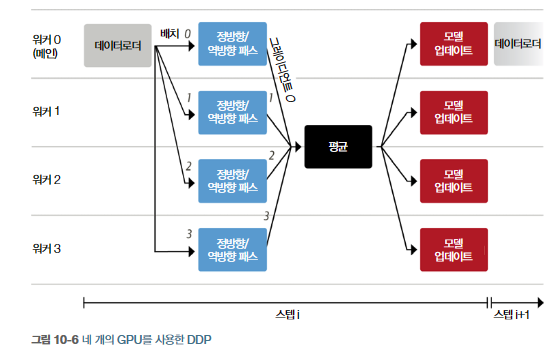

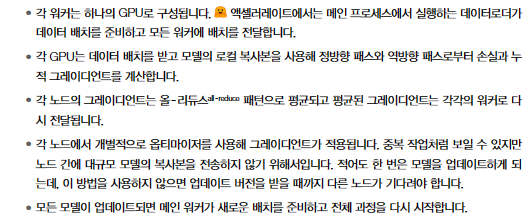

### 10.3.5 훈련 실행

훈련 스크립트</br>
https://huggingface.co/transformersbook/codeparrot/edit/main/codeparrot_training.py

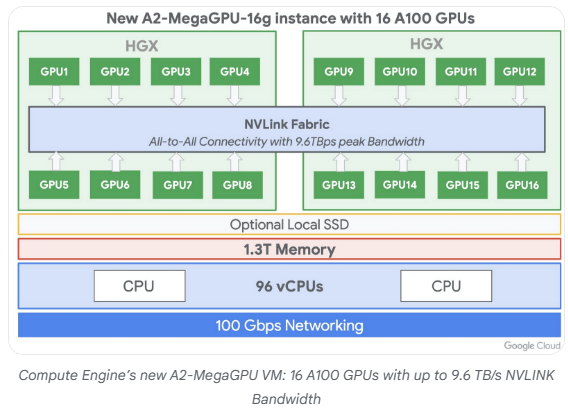

## 결과 및 분석

훈련 소실과 검증 복잡도는 지속적으로 감소, 손실 곡선은 로그-로그 스케일에서 거의 선형

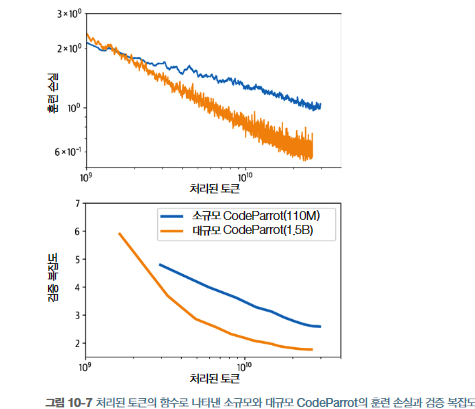

In [67]:
from transformers import pipeline, set_seed

model_ckpt = 'transformersbook/codeparrot-small'
generation = pipeline('text-generation', model=model_ckpt, device=-1) # GPU는 0으로...

In [90]:
import re
from transformers import set_seed

def first_block(string):
    return re.split('\nclass|\ndef|\n#|\n@|\nprint|\nif', string)[0].rstrip()

def complete_code(pipe, prompt, max_length=64, num_completions=4, seed=1):
    set_seed(seed)
    # 생성 설정
    gen_kwargs = {"temperature":0.4, "top_p":0.95, "top_k":0, "num_beams":1,
                  "do_sample":True,}
    code_gens = generation(prompt, num_return_sequences=num_completions,
                            max_length=max_length, **gen_kwargs)
    code_strings = []
    for code_gen in code_gens:
        # print(code_gen['generated_text'][len(prompt):])
        generated_code = first_block(code_gen['generated_text'][len(prompt):])
        # print(generated_code)
        code_strings.append(generated_code)
    print(('\n'+'='*80 + '\n').join(code_strings))

first_block은 입력 문자열에서 첫 번째 "블록"을 추출하는 역할</br>
새로운 클래스, 함수 정의, 주석, 데코레이터, Print, if문

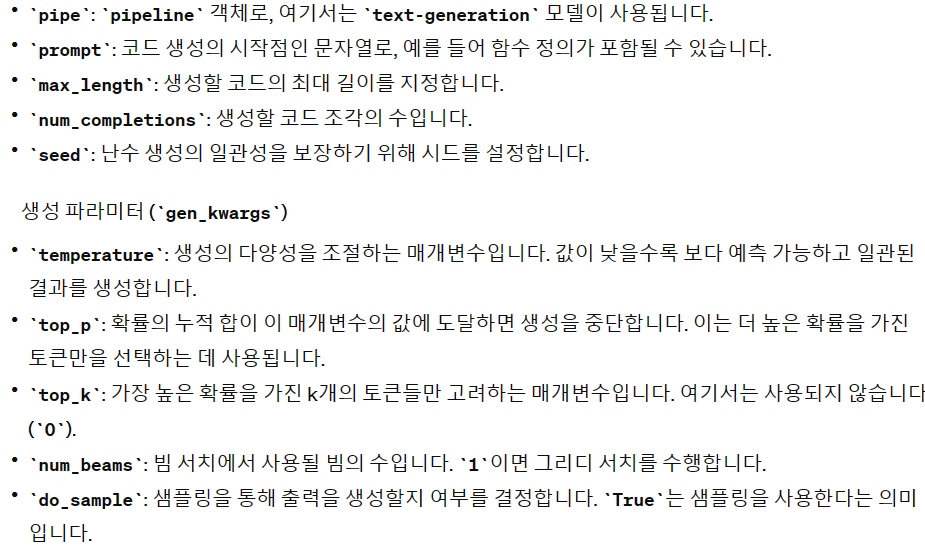

In [91]:
prompt = '''def area_of_rectangle(a: float, b: float):
    """Return the area of the rectangle."""'''
complete_code(generation, prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    return (a / b) * (a + b) / 2.0

    return a * b

    return a / b

    return a / b


In [92]:
prompt = '''def area_of_triangle(a: float, b: float, c: float):
    """Return the area of the triangle."""'''
complete_code(generation, prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    return (a - b) / (a + b)

    return a * b / c

    return a / b * c

    return a / b * c


In [89]:
def test_block(string):
    return re.split('\nclass|\n#|\n@|\nprint|\nif', string)[0].rstrip()
code = """
def hello_world():
    print("Hello, world!")
    return
# New comment
@decorator
def another_function():
    pass
"""
a=test_block(code)
a

'\ndef hello_world():\n    print("Hello, world!")\n    return'

HTML에서 URL을 추출

In [93]:
prompt = '''def get_urls_from_html(html):
    """Get all embedded URLs in a HTML string."""'''
complete_code(generation, prompt)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    return [url for url in re.findall(r'<a href="(http://[^"]+\.html)"', html)]

    return [url for url in re.findall(r'<a href="(.*?)"', html) if url]

    return [url for url in re.findall(r'<a href="(.*?)"', html) if url]

    return [url for url in re.findall(r'<a href="(.*?)" class="url">', html)]


In [94]:
import requests

def get_urls_from_html(html):
    return [url for url in re.findall(r'<a href="(.*?)"', html) if url]

print(" | ".join(get_urls_from_html(requests.get('https://hf.co/').text)))

/chat | /models | /spaces/CohereForAI/c4ai-command-r-plus | /spaces/jbilcke-hf/ai-comic-factory | /spaces/multimodalart/face-to-all | /spaces/HuggingFaceH4/open_llm_leaderboard | /spaces/lmsys/chatbot-arena-leaderboard | /spaces | /datasets | /enterprise | /enterprise | /enterprise | /enterprise | /enterprise | /enterprise | /docs/transformers | /docs/diffusers | /docs/safetensors | /docs/huggingface_hub | /docs/tokenizers | /docs/peft | /docs/transformers.js | /docs/timm | /docs/trl | /docs/datasets | /docs/text-generation-inference | /docs/accelerate


파이썬 함수를 넘파이를 사용한 함수로...

In [96]:
model_ckpt = 'transformersbook/codeparrot-small'
generation = pipeline('text-generation', model=model_ckpt, device=-1)

prompt = '''# a function in native python:
def mean(a):
    return sum(a)/len(a)

# the same function using numpy:
import numpy as np
def mean(a):'''
complete_code(generation, prompt, max_length=64)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



    return mean(a)

    return np.mean(a)

    return np.mean(a)

    return mean(a)/len(a)


사이킷런 모델로...

In [97]:
prompt = '''X = np.random.randn(100, 100)
y = np.random.randint(0, 1, 100)

# fit random forest classifier with 20 estimators'''
complete_code(generation, prompt, max_length=96)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



clf = RandomForestClassifier(n_estimators=20, max_depth=1, random_state=1)
clf.fit(X, y)
 and 50 features
clf = RandomForestClassifier(n_estimators=20, max_features=1, random_state=1)
clf.fit(X, y)
 and 10 classes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = RandomForestClassifier(n_estimators=20, max_features=20)
clf.fit(X, y)


생성된 텍스트 품질 측정 방법:BLEU, ROUGE 등... 있으나</br>
소프트웨어 분야에서는 적절하지 않다...</br>
유닛 테스트와 같은 코드 품질 측정 방법: 테스트 실행, 통과 비율 계산

## 10.5 결론

이번 장에서는...
- 파이썬 자동 완성 함수
- 대규모 언어 모델 훈련을 위한 대규모 데이터셋 구축
- 파이썬코드를 효율적으로 인코딩하는 사용자 정의 토크나이저
- 액셀러레이트 훈련 스크립트로 분산 훈련

--------------------------------------------------------------------------